# Základni úvod do pythonu

In [1]:
# First we import the necessary modules (libraries)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from urllib import urlopen
import os
from IPython import get_ipython



#baseURL = "http://golem.fjfi.cvut.cz/utils/data/" #global
baseURL = "/golem/database/operation/shots/" #local


def open_data(shot_no):
    f = baseURL + str(shot_no) + '/' + str(diagnSPEC) + '.npz'
    return np.load(f)

# Definice klouzaveho prumeru
def running_mean(l, N):
    sum = 0
    result = list( 0 for x in l)

    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)

    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N

    return result

def mkdir(dir):
    try:os.makedirs(dir)
    except OSError:pass
    
mkdir('raws'); mkdir('avmean'); mkdir('rezy');mkdir('rezy.jpg');mkdir('ReferenceShot');mkdir('graphs')




# Setup experimentu

In [4]:
#Probe specification: Double rake probe, pin #2
diagnSPEC = "DAS/1011Papouch_St.ON/Papouch_St_10"
#Power supply: 6 x 12V battery
R=20 # Ohm
d=21.4 # ??? mm (probe position with respect to the plasma center, suplera 53 mm - 31.6 mm)


# Numerický setup experimentu

In [5]:
KlouzavyPrumer=500;
#time=[5000,24000,KlouzavyPrumer];  # [start,end,step] [us]
time=[10000,14000,500];  # [start,end,step] [us] #just for tuning

# Který shot patří ke kterému napětí:
setup=[[-77,23998],[-65,23999],[-52,24000],[-39,24001],[-26,24002],[-13,24003],[0,24004],[12,24005],[26,24006],[39,24008],[51,24009],[64,24010],[77,24011]]
startindex=setup[0][1]

ReferenceShot=24004



# Referencni vyboj

In [6]:
print "Referencni vyboj ..."
os.system('scp '+baseURL + str(ReferenceShot) + '/basicdiagn/Btoroidal.npz ReferenceShot/Btoroidal.npz');
os.system('scp '+baseURL + str(ReferenceShot) + '/basicdiagn/Iplasma.npz ReferenceShot/Iplasma.npz');
os.system('scp '+baseURL + str(ReferenceShot) + '/basicdiagn/graphpres.png ReferenceShot/');
Iplasma=np.load('ReferenceShot/Btoroidal.npz');
Btoroidal=np.load('ReferenceShot/Iplasma.npz');

f,ax = plt.subplots(2,sharex=True);
ax[0].plot(Btoroidal['data']);
ax[1].plot(Iplasma['data']);
ax[0].axvline(10000);
ax[1].axvline(10000);
plt.close();


Referencni vyboj ...


# Stažení, uložení a vykreslení čistých dat z BPP


In [7]:
print "Stazeni a vykresleni raw dat"
Scale=open_data(ReferenceShot)['scale']
plt.ylim(-10,2);plt.xlim(time[0],time[1]);
# Stazeni a ulozeni
for i in setup:
    if  not os.path.isfile('raws/'+str(i[1])):
        np.savetxt('raws/'+str(i[1]),open_data(str(i[1]))['data']*Scale)
    
# Vykresleni
for i in setup:    
    plt.plot(np.loadtxt('raws/'+str(i[1])),label=str(i[0])+' V'); 
    

    
plt.legend(loc=(1.1, 0)); 
plt.ylabel('$U_R$ [V]')
plt.xlabel('$t$ [us]')
plt.savefig('graphs/raws.jpg', bbox_inches='tight')
plt.close();


Stazeni a vykresleni raw dat


# Vyklouzaná data

In [17]:
print "Vyklouzani dat ..."
plt.ylim(-5,1);plt.xlim(time[0],time[1]);

for i in setup:    
    np.savetxt('avmean/'+str(i[1]),running_mean(np.loadtxt('raws/'+str(i[1])),KlouzavyPrumer));    


# Vykresleni
for i in setup:    
    plt.plot(np.loadtxt('avmean/'+str(i[1])),label=str(i[0])+' V'); 
    
plt.legend(loc=(1.1, 0));
plt.ylabel('$U_R$ [V]')
plt.xlabel('$t$ [us]')
plt.savefig('graphs/vyklouzani.jpg', bbox_inches='tight')
plt.close();


Vyklouzani dat ...


# Udelejme rezy

In [18]:
def partfig(data,timemark):
    fig, ax1 = plt.subplots();
    ax1.set_ylim(-5,0.5);
    ax1.plot(data, 'ro');
    ax1.set_ylabel('$U_R$ [V]')
    ax1.set_xlabel('$U_{bias}$ [V] (#+ShotNo)')
    ax1.axhline(0);
    ax1.set_title('t='+str(timemark*1.0/1000)+' ms')
    ax1.set_xticks([i for i in xrange(0,len(setup),1)])
    ax1.set_xticklabels([str(setup[i][0])+'V \n (#'+str(setup[i][1])+')' for i in xrange(0,len(setup),1)], rotation=90)
    ax2 = fig.add_axes([0.25, 0.25, 0.3, 0.18]);
    ax2.set_xlim(time[0],time[1]);
    ax2.set_yticks([i for i in xrange(0,4000,1000)])
    ax2.set_yticklabels([i for i in xrange(0,4,1)])
    ax2.set_xticks([i for i in xrange(time[0],time[1],2000)])
    ax2.set_xticklabels([i for i in xrange(time[0]/1000,time[1]/1000,2)])
    ax2.plot(Btoroidal['data']);
    ax2.axvline(timemark);
    ax2.set_ylabel('$I_p$ [kA]')
    ax3 = fig.add_axes([0.25, 0.43, 0.3, 0.18]);
    ax3.set_yticks([0,0.1,0.2,0.3,0.4])
    ax3.set_xticklabels([]);
    ax3.set_xlim(time[0],time[1]);
    ax3.plot(Iplasma['data']);
    ax3.axvline(timemark);
    ax3.set_ylabel('$B_t$ [T]')
    ax2.set_xlabel('$t$ [ms]')
    #plt.show(); #just for tuning
    plt.savefig('rezy.jpg/'+str(timemark)+'.jpg', bbox_inches='tight');
    plt.close();
    
#partfig(np.loadtxt('rezy/'+str(11200)),11200)    #just for tuning

In [20]:
print "Rezani .."
#Prvni nacteme data do velke matice
data=[];
for i in setup:data.append(np.loadtxt('avmean/'+str(i[1])));


# A tady to narezeme a vygenerujeme obrazky
for j in xrange(time[0],time[1],time[2]): 
    print "Rez .."+str(j)+"/"+str(time[1])+"\n"
    timeslot=[]
    k=0;
    for i in setup: 
        timeslot.append(data[k][j]);
        k=k+1;
    np.savetxt('rezy/'+str(j),timeslot);
    partfig(timeslot,j)

Rezani ..
Rez ..5000/20000

Rez ..7000/20000

Rez ..9000/20000

Rez ..11000/20000

Rez ..13000/20000

Rez ..15000/20000

Rez ..17000/20000

Rez ..19000/20000



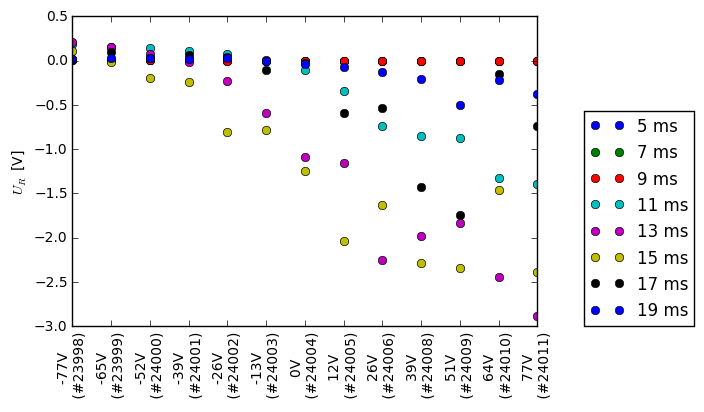

In [23]:
# A tady to nakreslime po ms
for j in xrange(time[0],time[1],time[2]): 
    plt.plot(np.loadtxt('rezy/'+str(j)),'o',label=str(j*1.0/1000)+' ms');
plt.legend(loc=(1.1, 0));
plt.ylabel('$U_R$ [V]')
plt.xticks([i for i in xrange(0,len(setup),1)],[str(setup[i][0])+'V \n (#'+str(setup[i][1])+')' for i in xrange(0,len(setup),1)], rotation=90);
plt.savefig('graphs/mss.jpg', bbox_inches='tight')

# Tvorba reportu

In [24]:
os.system('rm index.page');
fileid = open('index.page','a+')
fileid.write('---\nformat:markdown\n...\n')
fileid.write('# Experimental setup\n\n')
fileid.write('<center><a href="setup/ExpSetup.png"><img src="setup/ExpSetup.png" width="50%"></a>\n\n[setup](setup/)\n</center>\n')
fileid.write('# Reference shot #'+str(ReferenceShot)+'\n')
fileid.write('<center><a href="http://golem.fjfi.cvut.cz/shots/'+str(ReferenceShot)+'/"><img src="ReferenceShot/graphpres.png" width="50%"></a>\n\n[Reference shot data](ReferenceShot/)\n</center>\n')
fileid.write('# Discharges\n<ul>\n');
for i in setup:fileid.write('<li><a href="http://golem.fjfi.cvut.cz/shots/'+str(i[1])+'">U<sub>bias</sub>='+str(i[0])+'V @ #'+str(i[1])+'</a></li>\n');
fileid.write('</ul>\n');
fileid.write('# Data manipulation\n');
fileid.write('## Raw data\n')
fileid.write('<center><img src="graphs/raws.jpg">\n\n[raw data ->](raws/)\n</center>\n')
fileid.write('## mean average (over '+str(KlouzavyPrumer)+' data)\n')
fileid.write('<center><img src="graphs/vyklouzani.jpg">\n\n[mean average data ->](avmean/)\n</center>\n')
fileid.write('## Alltogether ('+str(KlouzavyPrumer)+'us step)\n')
fileid.write('<center><img src="graphs/mss.jpg">\n\n[time cuts](rezy/)\n</center>\n')
fileid.write('# Final movie\n')
fileid.write('<center><img src="finalmovie.gif">\n\n[time cuts - figures](rezy.jpg/)\n</center>\n')
fileid.write('# Experimental Photo\n') 
fileid.write('<center><img src="setup/ExpSetupPhoto_w.jpg"></center>\n\n')
fileid.write('# Resources\n')
fileid.write('\n\
* [python Source code](Analyza.html)\n\
* [Jupyter notebook](Analyza.ipynb)\n\
* [important makefile (this is how we do it - i.e. remove "tuning issues, etc.")](makefile)\n\
')             
fileid.close()

